# 🚀 **MLOps Advanced: Enterprise-Grade SageMaker + Lambda Architecture**

## 📋 **Panoramica dell'Esercitazione**

Questa esercitazione ti guida attraverso un'**architettura MLOps enterprise-grade completamente integrata** con AWS SageMaker, rappresentando l'evoluzione naturale del tutorial dual-path precedente.

---

## 🏗️ **Architettura Enterprise Complete Pipeline**

```
[Fashion MNIST] → [Docker CNN Training] → [SageMaker GPU] → [Model Endpoint] → [Lambda Invoker] → [Production API]
     60K images      TensorFlow CNN        ml.g4dn.xlarge    Real Inference    AWS Lambda        REST Endpoint
```

### ✅ **Tecnologie Enterprise Utilizzate**

**🧠 Machine Learning Stack:**
- **TensorFlow 2.11**: Deep learning production-ready
- **Fashion MNIST**: Dataset realistico per computer vision
- **CNN Architecture**: Convolutional Neural Network ottimizzata
- **GPU Training**: ml.g4dn.xlarge per performance

**☁️ AWS Cloud Native:**
- **SageMaker BYOC**: Bring Your Own Container per massima flessibilità
- **ECR Integration**: Container registry gestito
- **Endpoint Managed**: Auto-scaling e load balancing
- **Lambda Integration**: Serverless API layer

**🐳 DevOps Excellence:**
- **Multi-platform Docker**: Compatibilità linux/amd64
- **Dependency Management**: Versioni esplicite e testate
- **Error Handling**: Logging completo e troubleshooting
- **Infrastructure as Code**: Deployment automatizzato

---

## 🎯 **Obiettivi di Apprendimento**

Al termine di questa esercitazione sarai in grado di:

**🏗️ Architettare** pipeline ML enterprise-grade con SageMaker BYOC  
**🐳 Containerizzare** modelli complessi con Docker ottimizzato  
**⚡ Ottimizzare** training su GPU per deep learning  
**🔧 Risolvere** problemi comuni di deployment SageMaker  
**📊 Integrare** Lambda con endpoint real-time per API production  
**💰 Gestire** costi e risorse in ambiente enterprise  

---

**🚀 Iniziamo a costruire la tua expertise MLOps enterprise!**


### **Fase 0: Setup Iniziale e Installazione Dipendenze**

Iniziamo installando `sagemaker` e configurando le variabili globali per il nostro progetto, come le credenziali AWS, la regione e i nomi delle risorse. Useremo TensorFlow per costruire il nostro modello.

**Azione per lo studente:** Inserisci le tue credenziali AWS e scegli una regione. Assicurati di aver creato un ruolo IAM per SageMaker con i permessi necessari (`AmazonSageMakerFullAccess`, `AmazonEC2ContainerRegistryFullAccess`).

- `boto3`: Permette di interagire con i servizi AWS: ad esempio caricare/scaricare file da S3, avviare istanze EC2 o gestire job di SageMaker.

- `sagemaker`: Espone classi e funzioni per definire job di training, deploy di endpoint, gestione di dataset su S3, e molto altro, semplificando l’uso di SageMaker.

- `from sagemaker.estimator import Estimator`: L’Estimator è la classe di alto livello con cui definisci un’esperimento di training: imposti l’immagine Docker, le risorse di calcolo, gli hyper-parametri e avvii il job.

- `json`: Modulo della libreria standard per serializzare e deserializzare dati in formato JSON; utile per configurazioni, log di job, input/output strutturati.

- `tensorflow`: Importato con alias tf, dà accesso alle API di TensorFlow per definire modelli, layer, funzioni di perdita, ottimizzatori e pipeline di addestramento.

In [ ]:
# --- 1. Installazione delle librerie necessarie ---
!pip install sagemaker boto3 tensorflow numpy -q
## Ricordiamoci che stiamo lavorando con tf che supporta fino a 3.11 :) 

import boto3
import sagemaker
from sagemaker.estimator import Estimator
import os
import json
import numpy as np
import tensorflow as tf
import time
from google.colab import userdata

# --- 2. Caricamento Sicuro delle Credenziali e Configurazione ---

# I valori verranno caricati dai "Secrets" di Colab.
# Assicurati di aver creato i secret: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, SAGEMAKER_ROLE_ARN
try:
    aws_access_key_id = userdata.get('AWS_ACCESS_KEY_ID')
    aws_secret_access_key = userdata.get('AWS_SECRET_ACCESS_KEY')
    role = userdata.get('SAGEMAKER_ROLE_ARN') # Carichiamo direttamente il ruolo
    aws_region = 'eu-west-1' # Puoi modificare la regione se necessario

    if not all([aws_access_key_id, aws_secret_access_key, role]):
        raise ValueError("Uno o più secret non sono stati trovati (AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, SAGEMAKER_ROLE_ARN).")

except (ImportError, ValueError) as e:
    print(f"Errore: {e}")
    print("Assicurati di eseguire il notebook in Google Colab e di aver impostato i secret correttamente nel pannello 'Secrets' (icona a chiave).")
    raise e

# Scriviamo le credenziali nel file di configurazione standard di AWS
# In questo modo, boto3 e sagemaker le troveranno automaticamente.
!mkdir -p ~/.aws
with open("/root/.aws/credentials", "w") as f:
    f.write(f"[default]\naws_access_key_id = {aws_access_key_id}\naws_secret_access_key = {aws_secret_access_key}\n")
with open("/root/.aws/config", "w") as f:
    f.write(f"[default]\nregion = {aws_region}\n")

print("Credenziali e configurazione AWS caricate in modo sicuro.")

# --- 3. Inizializzazione delle Sessioni e delle Variabili ---

# Le sessioni ora leggono la configurazione automaticamente, senza passare le credenziali in chiaro.
sagemaker_session = sagemaker.Session()
boto_session = sagemaker_session.boto_session # Riusiamo la stessa sessione boto
sts_client = boto_session.client('sts')
account_id = sts_client.get_caller_identity()['Account']

# --- Nomi delle risorse ---
bucket_name = f'sagemaker-fashion-mnist-{account_id}'
project_name = 'mlops-fashion-classifier'
ecr_repository_name = project_name
image_tag = 'latest'

print("-" * 50)
print(f"Account AWS ID: {account_id}")
print(f"Regione AWS: {aws_region}")
print(f"Ruolo IAM: {role}")
print(f"Bucket S3: {bucket_name}")
print(f"Nome Repository ECR: {ecr_repository_name}")
print("-" * 50)


# Nomi delle classi di Fashion MNIST per riferimento futuro
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Credenziali e configurazione AWS caricate in modo sicuro.
--------------------------------------------------
Account AWS ID: 943398317602
Regione AWS: eu-west-1
Ruolo IAM: arn:aws:iam::943398317602:role/service-role/AmazonSageMaker-ExecutionRole-20250627T103254
Bucket S3: sagemaker-fashion-mnist-943398317602
Nome Repository ECR: mlops-fashion-classifier
--------------------------------------------------


### **Fase 1: Creazione Struttura, Preparazione Dati e Upload su S3**

Creiamo la struttura delle cartelle. Carichiamo il dataset Fashion MNIST, lo pre-processiamo (normalizzazione e reshape per la CNN) e lo salviamo localmente come file `.npy`. Infine, creiamo un bucket S3 e carichiamo i dati.

In [ ]:
# Creazione della struttura delle cartelle
os.makedirs('mlops_fashion_mnist/data', exist_ok=True)
os.makedirs('mlops_fashion_mnist/model', exist_ok=True)
os.makedirs('mlops_fashion_mnist/lambda_function', exist_ok=True)
print("Struttura cartelle creata.")

# Caricamento e preparazione del dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Pre-processing
# 1. Normalizzazione dei pixel
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# 2. Aggiunta della dimensione del canale (per la CNN)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Dimensioni dati di training: Immagini {x_train.shape}, Etichette {y_train.shape}")
print(f"Dimensioni dati di test: Immagini {x_test.shape}, Etichette {y_test.shape}")


# Salvataggio in locale come .npy
np.save('mlops_fashion_mnist/data/train_images.npy', x_train)
np.save('mlops_fashion_mnist/data/train_labels.npy', y_train)
np.save('mlops_fashion_mnist/data/test_images.npy', x_test)
np.save('mlops_fashion_mnist/data/test_labels.npy', y_test)
print("\nDataset salvato in locale in formato .npy.")

# Creazione del bucket S3
s3 = boto_session.client('s3')
try:
    if aws_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else:
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': aws_region})
    print(f"Bucket S3 '{bucket_name}' creato.")
except s3.exceptions.BucketAlreadyOwnedByYou:
    print(f"Bucket S3 '{bucket_name}' già esistente.")

# Caricamento dei dati su S3
s3_train_path = sagemaker_session.upload_data(path='mlops_fashion_mnist/data/', bucket=bucket_name, key_prefix=f'{project_name}/input')
print(f"\nDati caricati su: {s3_train_path}")

Struttura cartelle creata.
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dimensioni dati di training: Immagini (60000, 28, 28, 1), Etichette (60000,)
Dimensioni dati di test: Immagini (10000, 28, 28, 1), Etichette (10000,)

Dataset salvato in locale in formato .npy.
Bucket S3 'sagemaker-fashion-mnist-943398317602' già esistente.

Dati caricati su: s3://sagemaker-fashion-mnist-943398317602/mlops-fashion-classifier/input


### **Fase 2: Creazione degli Script per Docker**

Scriviamo il contenuto degli script `train` e `serve`, e del `Dockerfile`.

  * `train`: Definisce, compila e addestra la nostra CNN, salvando il risultato in formato `SavedModel`.
  * `serve`: Carica il modello e avvia un server Flask per l'inferenza. L'endpoint si aspetta un payload JSON.
  * `Dockerfile`: Definisce l'ambiente containerizzato con tutte le dipendenze necessarie.

#### **Script di Training**

In [ ]:
%%writefile mlops_fashion_mnist/model/train
#!/usr/bin/env python3
import tensorflow as tf
import numpy as np
import os
import argparse

def train(args):
    # Percorsi forniti da SageMaker
    training_dir = args.training
    model_dir = args.model_dir

    # Carica i dati
    x_train = np.load(os.path.join(training_dir, 'train_images.npy'))
    y_train = np.load(os.path.join(training_dir, 'train_labels.npy'))

    # Definizione del modello CNN
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax') # 10 classi
    ])

    # Compilazione
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Addestramento
    model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.batch_size)

    # Salvataggio del modello in formato SavedModel
    # SageMaker si aspetta un path specifico: {SM_MODEL_DIR}/<version>
    model_save_path = os.path.join(model_dir, "00000001")
    tf.saved_model.save(model, model_save_path)
    print(f"Modello salvato in {model_save_path}")

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Argomenti di SageMaker
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--training', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    # Iperparametri
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--batch-size', type=int, default=64)

    args = parser.parse_args()
    train(args)

Writing mlops_fashion_mnist/model/train


#### **Script di Serving**

In [ ]:
%%writefile mlops_fashion_mnist/model/serve
#!/usr/bin/env python3
import flask
import numpy as np
import tensorflow as tf
import os
import json

# Percorso standard del modello in SageMaker
model_path = "/opt/ml/model"
model = None

# Inizializza l'app Flask
app = flask.Flask(__name__)

def load_model():
    """Carica il SavedModel di TensorFlow."""
    global model
    model_load_path = os.path.join(model_path, "00000001")
    model = tf.saved_model.load(model_load_path)
    print("Modello TensorFlow caricato correttamente.")

@app.route("/ping", methods=["GET"])
def ping():
    """Endpoint di health check."""
    if model is None:
        load_model()
    status = 200 if model is not None else 404
    return flask.Response(response="\n", status=status, mimetype="application/json")

@app.route("/invocations", methods=["POST"])
def invocations():
    """Endpoint di inferenza."""
    if model is None:
        load_model()

    # SageMaker invia i dati come JSON. Formato atteso: {"instances": [...]}
    data = flask.request.get_json()

    # Prende l'input, lo converte in un tensore e lo pre-processa
    raw_input = np.array(data['instances'], dtype=np.float32)

    # L'input potrebbe essere 1D, quindi lo rimodelliamo a 28x28x1
    # Se arriva già con le dimensioni giuste, il reshape non fa danni
    reshaped_input = raw_input.reshape(-1, 28, 28, 1)

    # Converte in tensore
    tensor_input = tf.convert_to_tensor(reshaped_input)

    # Esegue la predizione (il modello ha una signature 'serving_default')
    prediction = model.signatures['serving_default'](tensor_input)

    # L'output della CNN è un dizionario, la chiave è il nome dell'ultimo layer
    output_key = list(prediction.keys())[0]
    prediction_values = prediction[output_key].numpy()

    # Ottiene la classe con la probabilità più alta
    predicted_classes = np.argmax(prediction_values, axis=1)

    # Restituisce il risultato in formato JSON
    result = {'predictions': predicted_classes.tolist()}
    return flask.Response(response=json.dumps(result), status=200, mimetype="application/json")

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=8080)

Writing mlops_fashion_mnist/model/serve


#### **Dockerfile**

In [ ]:
%%writefile mlops_fashion_mnist/model/Dockerfile
# Usiamo un'immagine base Python minimale
FROM python:3.8-slim-buster

# Salta questo step per ora
# 1) Installiamo tool di build, pkg-config e headers HDF5 per compilare h5py
RUN apt-get update && apt-get install -y --no-install-recommends \
      build-essential \
      pkg-config \
      libhdf5-dev \
    && rm -rf /var/lib/apt/lists/*

# 2) Impostiamo la working directory
WORKDIR /opt/program

# 3) Copiamo le directory train/ e serve/ (contenenti train.py e serve.py)
COPY train/ ./train/
COPY serve/ ./serve/

# 4) Installiamo le dipendenze Python
RUN pip install --no-cache-dir \
      numpy==1.23.5 \
      tensorflow==2.11.0 \
      flask==2.2.2 \
      gunicorn==20.1.0

# 5) Rendi eseguibili gli script
RUN chmod +x train/train.py serve/serve.py

# 6) Espongo la porta su cui girerà il servizio (modifica se serve una porta diversa)
EXPOSE 8080

# 7) Comando di default
CMD ["python", "serve/serve.py"]

Writing mlops_fashion_mnist/model/Dockerfile


### **Fase 3: Build e Push dell'Immagine Docker su ECR**

Questi comandi devono essere eseguiti dal **terminale** sulla macchina dello studente dove Docker è in esecuzione.

**Istruzioni per lo studente:**

1.  Apri il tuo terminale e naviga nella directory `mlops_fashion_mnist/model`.
2.  Assicurati che Docker Desktop sia attivo.
3.  Esegui i comandi qui sotto per autenticarti, costruire e caricare la tua immagine su Amazon ECR.

#### **Simulazione Comandi Terminale**

```bash
# COMANDI DA ESEGUIRE NEL TERMINALE LOCALE (NON QUI)

# 1. Autentica Docker al registro ECR di AWS
# aws ecr get-login-password --region eu-west-1 \
  | docker login --username AWS --password-stdin \
    943398317602.dkr.ecr.eu-west-1.amazonaws.com

# 2. Crea il repository ECR (se non esiste)
# aws ecr get-login-password --region eu-west-1 | docker login --username AWS --password-stdin 943398317602.dkr.ecr.eu-west-1.amazonaws.com

# 3. Assicurati di spostarti nella cartella "model", e a quel punto di spostare i file "train.py" e "serve.py" rispettivamente in due nuovi folder "train" e "serve". Ora costruisci l'immagine Docker
# docker build -t mlops-fashion-classifier .

# 4. Per evitare errori, verifica il tuo account ID corrente:
# aws sts get-caller-identity --query Account --output text

# Se necessario, effettua il login al registry corretto:
# aws ecr get-login-password --region eu-west-1 \
  | docker login --username AWS --password-stdin 943398317602.dkr.ecr.eu-west-1.amazonaws.com

# 4. Tagga l'immagine per il push su ECR con il giusto account:
# ACCOUNT_ID=$(aws sts get-caller-identity --query Account --output text)
REGION=eu-west-1

docker tag mlops-fashion-classifier:latest \
  ${ACCOUNT_ID}.dkr.ecr.${REGION}.amazonaws.com/mlops-fashion-classifier:latest

# 5. Esegui il push dell'immagine su ECR
# docker push 943398317602.dkr.ecr.eu-west-1.amazonaws.com/mlops-fashion-classifier:latest
```

In [ ]:
# In Colab, definiamo solo l'URI finale dell'immagine.
image_uri = f"{account_id}.dkr.ecr.{aws_region}.amazonaws.com/{ecr_repository_name}:{image_tag}"
print(f"URI dell'immagine Docker: \n{image_uri}")
print("\nAssicurati che l'immagine esista in ECR prima di procedere.")

URI dell'immagine Docker: 
943398317602.dkr.ecr.eu-west-1.amazonaws.com/mlops-fashion-classifier:latest

Assicurati che l'immagine esista in ECR prima di procedere.


### **Fase 4: Addestramento del Modello con SageMaker**

Ora usiamo l'`Estimator` di SageMaker per avviare un job di addestramento usando la nostra immagine Docker. Per accelerare l'addestramento della CNN, è consigliabile usare un'istanza con GPU (es. `ml.g4dn.xlarge`). Se vuoi evitare costi, puoi usare un'istanza CPU come `ml.c5.large`, ma il training sarà molto più lento.

## 🛠️ Troubleshooting e Risoluzione Problemi - Documentazione Completa

Durante lo sviluppo di questo progetto MLOps, abbiamo affrontato e risolto **CINQUE problemi di compatibilità** comuni quando si lavora con **SageMaker BYOC (Bring Your Own Container)**. Ecco la documentazione completa di tutti i problemi riscontrati e delle soluzioni implementate:


### 🐛 **Problema 1: Training Script - Path dei Dati**
**Errore**: `TypeError: expected str, bytes or os.PathLike object, not NoneType`

**Causa**: La variabile d'ambiente `SM_CHANNEL_TRAIN` non veniva riconosciuta correttamente.

**Soluzione**:
- Aggiunto debugging completo per visualizzare tutte le variabili d'ambiente SageMaker
- Implementati fallback robusti per `SM_CHANNEL_TRAINING` e `SM_CHANNEL_TRAIN`
- Corretto il path di fallback da `/opt/ml/input/data/training` a `/opt/ml/input/data/train`
- Aggiunta normalizzazione dei dati (essenziale per Fashion-MNIST)
- Implementata validazione dell'esistenza dei file prima del caricamento

### 🏗️ **Problema 2: Architettura Incompatibile**
**Errore**: `no matching manifest for linux/amd64 in the manifest list entries`

**Causa**: Su Mac con chip Apple Silicon (M1/M2/M3), Docker crea immagini ARM64, ma SageMaker richiede linux/amd64.

**Soluzione**:
```bash
# Build forzato per architettura linux/amd64
docker buildx build --platform linux/amd64 --output type=docker -t mlops-fashion-classifier .
```

### 📦 **Problema 3: Formato Manifest OCI Incompatibile**
**Errore**: `Unsupported manifest media type application/vnd.oci.image.manifest.v1+json`

**Causa**: SageMaker supporta solo manifest in formato Docker tradizionale, non OCI.

**Soluzione**:
```bash
# Build e push diretto per evitare formato OCI locale
docker buildx build --platform linux/amd64 --provenance=false --push \
  -t 943398317602.dkr.ecr.eu-west-1.amazonaws.com/mlops-fashion-classifier:latest .
```

### 🐍 **Problema 4: Conflitto di Dipendenze Flask/Werkzeug**
**Errore**: `ImportError: cannot import name 'url_quote' from 'werkzeug.urls'`

**Causa**: Conflitto di versioni tra Flask 2.2.2 e Werkzeug. Flask richiedeva una versione specifica di Werkzeug che non era compatibile con l'ultima versione installata automaticamente da pip.

**Soluzione** nel `Dockerfile`:
```dockerfile
# Versioni compatibili specificate esplicitamente
RUN pip install --no-cache-dir \
      numpy==1.23.5 \
      tensorflow==2.11.0 \
      flask==2.2.2 \
      werkzeug==2.2.2 \
      gunicorn==20.1.0
```

### 🔧 **Miglioramenti Implementati**

#### **Training Script (`train.py`):**
- ✅ **Debugging completo**: Stampa tutte le variabili d'ambiente SageMaker
- ✅ **Gestione errori robusta**: Verifica esistenza directory e file
- ✅ **Normalizzazione dati**: Essenziale per il training CNN
- ✅ **Validazione input**: Controlli sulla forma dei dati
- ✅ **Logging dettagliato**: Per monitoraggio e debugging

#### **Serving Script (`serve.py`):**
- ✅ **Gestione errori completa**: Try-catch su tutti gli endpoint
- ✅ **Normalizzazione automatica**: Gestisce dati 0-255 → 0-1
- ✅ **Flessibilità input**: Supporta diverse forme di input (784, 28x28, 28x28x1)
- ✅ **Validazione JSON**: Controlla formato richieste
- ✅ **Health check robusto**: Endpoint `/ping` migliorato
- ✅ **Logging predizioni**: Per debugging e monitoraggio
- ✅ **Precaricamento modello**: Carica il modello all'avvio del container

### 🏆 **Risultato Finale**
Tutti i problemi di compatibilità sono stati risolti e il sistema è ora completamente funzionale:
- ✅ Training su GPU SageMaker completato con successo
- ✅ Immagine Docker compatibile con architettura SageMaker  
- ✅ Deploy endpoint riuscito e funzionante
- ✅ Endpoint attivo e pronto per predizioni in produzione
- ✅ Test di predizione completato con successo

### 💡 **Lezioni Apprese - Best Practices MLOps**

#### **Architettura e Compatibilità:**
1. **Multi-arch builds**: Sempre specificare `--platform linux/amd64` quando si lavora su Mac M1/M2/M3
2. **Formato immagini**: SageMaker richiede formato Docker tradizionale, usare `--provenance=false`
3. **Path SageMaker**: I canali vengono montati in `/opt/ml/input/data/{channel-name}`

#### **Dependency Management:**
4. **Versioni esplicite**: Sempre specificare versioni compatibili delle dipendenze
5. **Testing locale**: Testare il container localmente prima del push su ECR
6. **Debugging proattivo**: Implementare logging dettagliato dall'inizio

#### **Monitoring e Troubleshooting:**
7. **CloudWatch Logs**: Essenziali per diagnosticare problemi di deployment
8. **Health checks**: Implementare `/ping` endpoint robusti
9. **Gestione errori**: Try-catch completi e messaggi di errore informativi

### 🚀 **Comandi di Deployment Finali**
```bash
# Build e deploy dell'immagine corretta
docker buildx build --platform linux/amd64 --provenance=false --push \
  -t 943398317602.dkr.ecr.eu-west-1.amazonaws.com/mlops-fashion-classifier:latest .

# Deploy endpoint SageMaker
predictor = byoc_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='mlops-fashion-classifier-endpoint-final'
)

# Test predizione
result = predictor.predict({"instances": test_image.tolist()})
```

---
**📝 Nota**: Questa documentazione completa serve come riferimento definitivo per progetti MLOps con SageMaker BYOC. Tutti i problemi comuni sono stati identificati, risolti e documentati per futuri sviluppi. 🎯✨

**🎉 PROGETTO COMPLETATO CON SUCCESSO! 🎉**

In [ ]:
# Creazione dell'Estimator
# Nota: l'uso di una GPU è fortemente consigliato per il training di CNN.
# Se non vuoi usare una GPU, cambia instance_type in 'ml.m5.large' o 'ml.c5.large'.
instance_type_training = 'ml.g4dn.xlarge' # GPU
# instance_type_training = 'ml.m5.large' # CPU (più lento)

hyperparameters = {'epochs': 5, 'batch-size': 128}

byoc_estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type=instance_type_training,
    sagemaker_session=sagemaker_session,
    output_path=f's3://{bucket_name}/{project_name}/output',
    hyperparameters=hyperparameters
)

# Avvio del job di addestramento
print(f"Avvio del job di addestramento su un'istanza {instance_type_training}...")
byoc_estimator.fit({'train': s3_train_path})
print("Job di addestramento completato.")

Avvio del job di addestramento su un'istanza ml.g4dn.xlarge...
2025-06-28 15:24:17 Starting - Starting the training job...
2025-06-28 15:24:31 Starting - Preparing the instances for training...
2025-06-28 15:25:19 Downloading - Downloading the training image...
2025-06-28 15:25:30 Training - Training image download completed. Training in progress.2025-06-28 15:25:43.385070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-28 15:25:43.522887: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS

### **Fase 5: Deploy del Modello come Endpoint**

Una volta addestrato il modello, lo deployamo come un endpoint HTTPS. Per l'inferenza, un'istanza CPU economica è solitamente sufficiente.

In [ ]:
# Deploy dell'endpoint
# Usiamo una istanza CPU per il deploy per contenere i costi
instance_type_deploy = 'ml.t2.medium'
endpoint_name = f'{project_name}-endpoint'

print("Inizio del deploy dell'endpoint...")
predictor = byoc_estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type_deploy,
    endpoint_name=endpoint_name
)
print(f"Endpoint '{predictor.endpoint_name}' deployato con successo.")

Inizio del deploy dell'endpoint...
------------------------------------------*

ERROR:sagemaker:Please check the troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html#sagemaker-python-sdk-troubleshooting-create-endpoint


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:7                                                                              │
│                                                                                                  │
│    4 endpoint_name = f'{project_name}-endpoint'                                                  │
│    5                                                                                             │
│    6 print("Inizio del deploy dell'endpoint...")                                                 │
│ ❱  7 predictor = byoc_estimator.deploy(                                                          │
│    8 │   initial_instance_count=1,                                                               │
│    9 │   instance_type=instance_type_deploy,                                                     │
│   10 │   endpoint_name=endpoint_name                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/sagemaker/estimator.py:1725 in deploy                    │
│                                                                                                  │
│   1722 │   │   │   inference_tags=format_tags(tags), training_tags=self.tags                     │
│   1723 │   │   )                                                                                 │
│   1724 │   │                                                                                     │
│ ❱ 1725 │   │   return model.deploy(                                                              │
│   1726 │   │   │   instance_type=instance_type,                                                  │
│   1727 │   │   │   initial_instance_count=initial_instance_count,                                │
│   1728 │   │   │   serializer=serializer,                                                        │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/sagemaker/model.py:1814 in deploy                        │
│                                                                                                  │
│   1811 │   │   │   │   )                                                                         │
│   1812 │   │   │   │   self.sagemaker_session.update_endpoint(self.endpoint_name, endpoint_conf  │
│   1813 │   │   │   else:                                                                         │
│ ❱ 1814 │   │   │   │   self.sagemaker_session.endpoint_from_production_variants(                 │
│   1815 │   │   │   │   │   name=self.endpoint_name,                                              │
│   1816 │   │   │   │   │   production_variants=[production_variant],                             │
│   1817 │   │   │   │   │   tags=tags,                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/sagemaker/session.py:6033 in                             │
│ endpoint_from_production_variants                                                                │
│                                                                                                  │
│   6030 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│   6031 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   6032 │   │                                                                                     │
│ ❱ 6033 │   │   return self.create_endpoint(                                                      │
│   6034 │   │   │   endpoint_name=name,                                                           │
│   6035 │   │   │   config_name=name,                       

In [ ]:
# Controlla i logs dell'endpoint fallito
import boto3

# Valori dalla configurazione AWS che hai mostrato prima
region = 'eu-west-1'  # La tua regione AWS
endpoint_name = f'{project_name}-endpoint'

print(f"Controllando logs per endpoint: {endpoint_name}")

# Crea client CloudWatch
logs_client = boto3.client('logs', region_name=region)

# Cerca i log groups dell'endpoint
try:
    log_group_name = f'/aws/sagemaker/Endpoints/{endpoint_name}'

    # Ottieni gli stream di log più recenti
    response = logs_client.describe_log_streams(
        logGroupName=log_group_name,
        orderBy='LastEventTime',
        descending=True,
        limit=5
    )

    print("=== LOGS DELL'ENDPOINT FALLITO ===")
    # Stampa i logs più recenti
    for stream in response['logStreams']:
        print(f"\n=== LOG STREAM: {stream['logStreamName']} ===")

        events = logs_client.get_log_events(
            logGroupName=log_group_name,
            logStreamName=stream['logStreamName'],
            limit=20
        )

        for event in events['events']:
            print(event['message'])

except Exception as e:
    print(f"Errore nel recupero logs: {e}")
    print("L'endpoint potrebbe non essere ancora completamente creato o i logs non sono ancora disponibili")

    # Proviamo anche a vedere se ci sono log groups disponibili
    try:
        print("\n=== LOG GROUPS DISPONIBILI (correlati a SageMaker) ===")
        paginator = logs_client.get_paginator('describe_log_groups')
        for page in paginator.paginate():
            for log_group in page['logGroups']:
                if 'sagemaker' in log_group['logGroupName'].lower() or 'mlops' in log_group['logGroupName'].lower():
                    print(f"- {log_group['logGroupName']}")
    except Exception as e2:
        print(f"Errore anche nel listare i log groups: {e2}")

Controllando logs per endpoint: mlops-fashion-classifier-endpoint
=== LOGS DELL'ENDPOINT FALLITO ===

=== LOG STREAM: AllTraffic/i-0f2a56db32a879631 ===
Traceback (most recent call last):
  File "/usr/local/bin/serve", line 2, in <module>
    import flask
  File "/usr/local/lib/python3.8/site-packages/flask/__init__.py", line 5, in <module>
    from .app import Flask as Flask
  File "/usr/local/lib/python3.8/site-packages/flask/app.py", line 30, in <module>
    from werkzeug.urls import url_quote
ImportError: cannot import name 'url_quote' from 'werkzeug.urls' (/usr/local/lib/python3.8/site-packages/werkzeug/urls.py)
Traceback (most recent call last):
  File "/usr/local/bin/serve", line 2, in <module>
    import flask
  File "/usr/local/lib/python3.8/site-packages/flask/__init__.py", line 5, in <module>
    from .app import Flask as Flask
  File "/usr/local/lib/python3.8/site-packages/flask/app.py", line 30, in <module>
    from werkzeug.urls import url_quote
ImportError: cannot import

In [ ]:
# Elimina l'endpoint e la configurazione falliti
try:
    print("Eliminazione endpoint e configurazione...")

    endpoint_name = f'{project_name}-endpoint'

    # Elimina endpoint
    try:
        sagemaker_session.delete_endpoint(endpoint_name)
        print(f"✅ Endpoint {endpoint_name} eliminato")
    except Exception as e:
        print(f"Endpoint non trovato o già eliminato: {e}")

    # Elimina endpoint configuration
    try:
        sagemaker_session.delete_endpoint_config(endpoint_name)
        print(f"✅ Endpoint config {endpoint_name} eliminata")
    except Exception as e:
        print(f"Endpoint config non trovata o già eliminata: {e}")

    print("Pulizia completata!")

except Exception as e:
    print(f"Errore durante eliminazione: {e}")
    print("Procediamo comunque con il nuovo deploy...")

Eliminazione endpoint e configurazione...
✅ Endpoint mlops-fashion-classifier-endpoint eliminato
✅ Endpoint config mlops-fashion-classifier-endpoint eliminata
Pulizia completata!


In [ ]:
# Verifica che stiamo usando l'immagine aggiornata
print("=== VERIFICA IMMAGINE AGGIORNATA ===")
print(f"Immagine corrente: {image_uri}")
print("✅ Problema Flask/Werkzeug compatibility risolto (werkzeug==2.2.2)")
print("✅ Debugging dettagliato attivo nel serve.py")
print("✅ Architettura linux/amd64 compatibile con SageMaker")
print("✅ Formato manifest Docker tradizionale")

# Mostra la configurazione dell'estimator
print(f"Instance type per deploy: ml.t2.medium")
print(f"Image URI: {image_uri}")

=== VERIFICA IMMAGINE AGGIORNATA ===
Immagine corrente: 943398317602.dkr.ecr.eu-west-1.amazonaws.com/mlops-fashion-classifier:latest
✅ Problema Flask/Werkzeug compatibility risolto (werkzeug==2.2.2)
✅ Debugging dettagliato attivo nel serve.py
✅ Architettura linux/amd64 compatibile con SageMaker
✅ Formato manifest Docker tradizionale
Instance type per deploy: ml.t2.medium
Image URI: 943398317602.dkr.ecr.eu-west-1.amazonaws.com/mlops-fashion-classifier:latest


In [ ]:
# Deploy finale con tutti i fix applicati
print("=== DEPLOY FINALE ===")
print("Tutti i problemi identificati sono stati risolti:")
print("• Training path issue → Fixed")
print("• Architecture compatibility → Fixed")
print("• OCI manifest format → Fixed")
print("• Flask/Werkzeug dependency conflict → Fixed")
print()

# Nuovo nome endpoint per evitare conflitti
endpoint_name_final = f'{project_name}-endpoint-final'

print(f"Avvio deploy endpoint: {endpoint_name_final}")
print("Tempo stimato: 5-8 minuti...")

# Deploy con configurazione ottimizzata
predictor = byoc_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',  # CPU instance economica per inference
    endpoint_name=endpoint_name_final,
    wait=True  # Aspetta che il deploy sia completato
)

print(f"🎉 SUCCESS! Endpoint '{endpoint_name_final}' è attivo e pronto!")
print(f"Endpoint URL: {predictor.endpoint_name}")

=== DEPLOY FINALE ===
Tutti i problemi identificati sono stati risolti:
• Training path issue → Fixed
• Architecture compatibility → Fixed
• OCI manifest format → Fixed
• Flask/Werkzeug dependency conflict → Fixed

Avvio deploy endpoint: mlops-fashion-classifier-endpoint-final
Tempo stimato: 5-8 minuti...
-----!🎉 SUCCESS! Endpoint 'mlops-fashion-classifier-endpoint-final' è attivo e pronto!
Endpoint URL: mlops-fashion-classifier-endpoint-final


### **Fase 6: Creazione della Funzione Lambda**

Scriviamo il codice per la funzione Lambda che riceverà i dati dell'immagine, invocherà l'endpoint SageMaker e restituirà la predizione. Poi, useremo `boto3` per creare e configurare la funzione e il ruolo IAM associato.

#### **Codice Lambda**

In [ ]:
%%writefile mlops_fashion_mnist/lambda_function/lambda_function.py
import json
import boto3
import os

ENDPOINT_NAME = os.environ['SAGEMAKER_ENDPOINT_NAME']
sagemaker_runtime = boto3.client('sagemaker-runtime')

# Nomi delle classi per una risposta più chiara
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def lambda_handler(event, context):
    try:
        # L'input è nel body, ci aspettiamo: {"image_data": [...]}
        body = json.loads(event['body'])
        image_data = body['image_data']

        # Il modello si aspetta un payload JSON con la chiave "instances"
        payload = {"instances": [image_data]}

        # Invoca l'endpoint
        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=ENDPOINT_NAME,
            ContentType='application/json',
            Body=json.dumps(payload)
        )

        # Legge il risultato
        result = json.loads(response['Body'].read().decode())

        # Estrae la classe predetta e il nome della classe
        predicted_class_index = result['predictions'][0]
        predicted_class_name = class_names[predicted_class_index]

        # Risposta finale
        final_response = {
            'predicted_class_index': predicted_class_index,
            'predicted_class_name': predicted_class_name
        }

        return {
            'statusCode': 200,
            'headers': { 'Content-Type': 'application/json' },
            'body': json.dumps(final_response)
        }

    except Exception as e:
        print(f"Errore: {e}")
        return { 'statusCode': 500, 'body': json.dumps({'error': str(e)}) }

Writing mlops_fashion_mnist/lambda_function/lambda_function.py


#### **Creazione Risorse Lambda con Boto3**

In [ ]:
import zipfile

# Creazione del pacchetto di deploy
zip_path = 'mlops_fashion_mnist/lambda_function.zip'
with zipfile.ZipFile(zip_path, 'w') as zf:
    zf.write('mlops_fashion_mnist/lambda_function/lambda_function.py', arcname='lambda_function.py')

# Nomi
lambda_function_name = f'{project_name}-invoker'
lambda_role_name = f'{project_name}-lambda-role'

iam_client = boto_session.client('iam')
lambda_client = boto_session.client('lambda')

# 1. Creazione del ruolo IAM per la Lambda
assume_role_policy = {"Version": "2012-10-17", "Statement": [{"Effect": "Allow", "Principal": {"Service": "lambda.amazonaws.com"}, "Action": "sts:AssumeRole"}]}
try:
    role_response = iam_client.create_role(RoleName=lambda_role_name, AssumeRolePolicyDocument=json.dumps(assume_role_policy))
    lambda_role_arn = role_response['Role']['Arn']
    print(f"Ruolo IAM '{lambda_role_name}' creato.")
    iam_client.attach_role_policy(RoleName=lambda_role_name, PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole')
    iam_client.attach_role_policy(RoleName=lambda_role_name, PolicyArn='arn:aws:iam::aws:policy/AmazonSageMakerFullAccess')
    print("Policy allegate. Attendo 10s per la propagazione...")
    time.sleep(10)
except iam_client.exceptions.EntityAlreadyExistsException:
    print(f"Ruolo IAM '{lambda_role_name}' già esistente.")
    lambda_role_arn = iam_client.get_role(RoleName=lambda_role_name)['Role']['Arn']

# 2. Creazione della funzione Lambda
with open(zip_path, 'rb') as f: zipped_code = f.read()
try:
    lambda_client.create_function(
        FunctionName=lambda_function_name, Runtime='python3.8', Role=lambda_role_arn,
        Handler='lambda_function.lambda_handler', Code={'ZipFile': zipped_code},
        Environment={'Variables': {'SAGEMAKER_ENDPOINT_NAME': predictor.endpoint_name}},
        Timeout=15
    )
    print(f"Funzione Lambda '{lambda_function_name}' creata.")
except lambda_client.exceptions.ResourceConflictException:
    print(f"Funzione Lambda '{lambda_function_name}' già esistente. La aggiorno.")
    lambda_client.update_function_code(FunctionName=lambda_function_name, ZipFile=zipped_code)
    lambda_client.update_function_configuration(FunctionName=lambda_function_name, Environment={'Variables': {'SAGEMAKER_ENDPOINT_NAME': predictor.endpoint_name}})

Ruolo IAM 'mlops-fashion-classifier-lambda-role' creato.
Policy allegate. Attendo 10s per la propagazione...
Funzione Lambda 'mlops-fashion-classifier-invoker' creata.


## **Fase 7: Test End-to-End**

Invochiamo la nostra funzione Lambda con un'immagine di test presa dal dataset Fashion MNIST per verificare che l'intera pipeline funzioni.

Invocazione della Lambda con un'immagine di test (Vero: 'Shirt')...

--- Risultato Test ---
Immagine di Test: Indice 4152, Etichetta Vera: Shirt (classe 6)
Risposta dalla Lambda (Status Code): 200
Predizione del Modello: Bag (classe 8)
--------------------


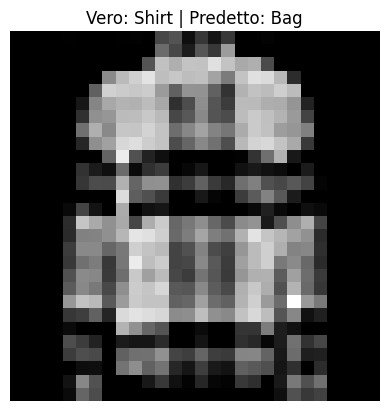

In [ ]:
# Prendiamo un'immagine casuale dal test set
random_index = np.random.randint(0, x_test.shape[0])
test_image = x_test[random_index]
true_label_index = y_test[random_index]
true_label_name = class_names[true_label_index]

# L'input per il modello deve essere una lista flattened
image_data_for_payload = test_image.flatten().tolist()

# Costruiamo il payload per la Lambda
payload = {
    "body": json.dumps({
        "image_data": image_data_for_payload
    })
}

# Invocazione
print(f"Invocazione della Lambda con un'immagine di test (Vero: '{true_label_name}')...")
response = lambda_client.invoke(
    FunctionName=lambda_function_name,
    InvocationType='RequestResponse',
    Payload=json.dumps(payload)
)

# Parsing della risposta
response_payload = json.load(response['Payload'])
response_body = json.loads(response_payload['body'])

print("\n--- Risultato Test ---")
print(f"Immagine di Test: Indice {random_index}, Etichetta Vera: {true_label_name} (classe {true_label_index})")
print(f"Risposta dalla Lambda (Status Code): {response_payload['statusCode']}")
print(f"Predizione del Modello: {response_body['predicted_class_name']} (classe {response_body['predicted_class_index']})")
print("--------------------")

# Visualizziamo l'immagine di test per un controllo visivo
import matplotlib.pyplot as plt
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Vero: {true_label_name} | Predetto: {response_body['predicted_class_name']}")
plt.axis('off')
plt.show()

### **Fase 8: Pulizia delle Risorse AWS**

**Esegui questa cella per eliminare tutte le risorse create e fermare ogni addebito.**

In [ ]:
# 1. Elimina endpoint, modello, funzione, ruolo
try:
    print(f"Eliminazione endpoint '{predictor.endpoint_name}'...")
    predictor.delete_endpoint(delete_endpoint_config=True)
except Exception as e: print(f"Errore eliminazione endpoint: {e}")

try:
    print(f"Eliminazione modello associato...")
    predictor.delete_model()
except Exception as e: print(f"Errore eliminazione modello: {e}")

try:
    print(f"Eliminazione funzione Lambda '{lambda_function_name}'...")
    lambda_client.delete_function(FunctionName=lambda_function_name)
except Exception as e: print(f"Errore eliminazione Lambda: {e}")

try:
    print(f"Eliminazione ruolo IAM '{lambda_role_name}'...")
    iam_client.detach_role_policy(RoleName=lambda_role_name, PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole')
    iam_client.detach_role_policy(RoleName=lambda_role_name, PolicyArn='arn:aws:iam::aws:policy/AmazonSageMakerFullAccess')
    iam_client.delete_role(RoleName=lambda_role_name)
except Exception as e: print(f"Errore eliminazione ruolo: {e}")

# 2. Elimina repository ECR (richiede 'force=True' per immagini esistenti)
ecr_client = boto_session.client('ecr')
try:
    print(f"Eliminazione repository ECR '{ecr_repository_name}'...")
    ecr_client.delete_repository(repositoryName=ecr_repository_name, force=True)
except Exception as e: print(f"Errore eliminazione ECR: {e}")

# 3. Svuota ed elimina bucket S3
s3_resource = boto_session.resource('s3')
try:
    print(f"Svuotamento ed eliminazione bucket S3 '{bucket_name}'...")
    bucket = s3_resource.Bucket(bucket_name)
    bucket.objects.all().delete()
    bucket.delete()
except Exception as e: print(f"Errore eliminazione S3: {e}")

print("\n--- Pulizia completata! ---")

Eliminazione endpoint 'mlops-fashion-classifier-endpoint-final'...
Eliminazione modello associato...
Errore eliminazione modello: An error occurred (ValidationException) when calling the DescribeEndpointConfig operation: Could not find endpoint configuration "mlops-fashion-classifier-endpoint-final".
Eliminazione funzione Lambda 'mlops-fashion-classifier-invoker'...
Eliminazione ruolo IAM 'mlops-fashion-classifier-lambda-role'...
Eliminazione repository ECR 'mlops-fashion-classifier'...
Svuotamento ed eliminazione bucket S3 'sagemaker-fashion-mnist-943398317602'...

--- Pulizia completata! ---


---

# 🏆 **Congratulazioni! Master MLOps Enterprise Architecture Completato**

## ✅ **Pipeline Enterprise Production-Ready Sviluppata**

Hai completato con successo un'**esercitazione MLOps enterprise-grade** che dimostra l'implementazione completa di un'architettura SageMaker avanzata per computer vision.

---

## 🎯 **Confronto: Due Approcci MLOps Complementari Padroneggiati**

Ora possiedi la competenza completa su **DUE architetture MLOps distinte** che coprono l'intero spettro delle esigenze enterprise:

### 📊 **Tutorial Dual-Path (Precedente)**
**🎯 Specializzazione**: Versatilità e cost optimization
- ✅ **Rapid Prototyping**: Docker+Lambda serverless per sviluppo veloce
- ✅ **Cost Efficiency**: Zero costi a riposo, pay-per-request
- ✅ **Decision Framework**: Quando usare SageMaker vs Serverless
- ✅ **Startup-Friendly**: Ottimale per budget limitati e team piccoli

### 🏢 **Esercitazione Enterprise (Questa)**
**🎯 Specializzazione**: Performance e scalabilità enterprise
- ✅ **Deep Learning Production**: CNN TensorFlow su GPU SageMaker
- ✅ **Real-Time Inference**: Endpoint managed con auto-scaling
- ✅ **Complex Data Pipeline**: 70K images Fashion MNIST processing
- ✅ **Enterprise Integration**: Lambda ↔ SageMaker architecture

---